In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/lfw.zip'

Streaming output truncated to the last 5000 lines.
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0021.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0021.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0020.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0020.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0008.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0008.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0022.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0022.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0023.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0023.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0012.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0012.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep

In [4]:

path = '/content/lfw'

In [5]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print ("cuda device not found.")


torch.Size([250, 250, 3])


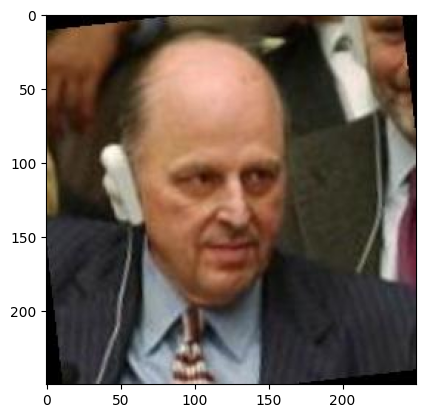

In [7]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [8]:

sample_image, _ = next(iter(dataloader))

# Print the dimensions of the image tensor
print("Image Shape:", sample_image.shape)


Image Shape: torch.Size([32, 3, 250, 250])


In the PyTorch tensor with size [32, 3, 250, 250]:

32 is the batch size, indicating there are 32 images in a batch.
3 represents the color channels (RGB) in each image.
250 is the height of each image.
250 is the width of each image.

It's a batch of 32 RGB images, each with dimensions 250x250 pixels.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AE(nn.Module):

    def __init__(self):
        super(AE, self).__init__()

        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.encoder_bn1 = nn.BatchNorm2d(16)
        self.encoder_pool1 = nn.MaxPool2d(kernel_size=2)

        self.encoder_conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.encoder_bn2 = nn.BatchNorm2d(32)
        self.encoder_pool2 = nn.MaxPool2d(kernel_size=2)

        # Decoder layers
        self.decoder_conv1 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.decoder_bn1 = nn.BatchNorm2d(16)

        self.decoder_conv2 = nn.Conv2d(in_channels=16, out_channels=3, kernel_size=3, padding=1)
        self.decoder_bn2 = nn.BatchNorm2d(3)

    def encoder(self, x):
        x = F.relu(self.encoder_bn1(self.encoder_conv1(x)))
        x = self.encoder_pool1(x)
        x = F.relu(self.encoder_bn2(self.encoder_conv2(x)))
        x = self.encoder_pool2(x)
        return x

    def decoder(self, x):
        x = F.interpolate(x, scale_factor=2, mode='nearest')  # Upsample to 124x124
        x = F.relu(self.decoder_bn1(self.decoder_conv1(x)))

        x = F.interpolate(x, size=(250, 250), mode='nearest')  # Upsample to 250x250
        x = torch.sigmoid(self.decoder_bn2(self.decoder_conv2(x)))  # Sigmoid activation for the last layer

        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [10]:
import torch

# Instantiate the Autoencoder model
autoencoder = AE()

# Print the model architecture
print(autoencoder)

# Choose a random image from the dataset
sample_image, _ = next(iter(dataloader))

# Forward pass through the encoder
with torch.no_grad():
    encoded_output = autoencoder.encoder(sample_image)

# Forward pass through the decoder
with torch.no_grad():
    decoded_output = autoencoder.decoder(encoded_output)

# Print the shapes of the encoder and decoder outputs
print("Shape of Encoder Output:", encoded_output.shape)
print("Shape of Decoder Output:", decoded_output.shape)


AE(
  (encoder_conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (decoder_conv1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decoder_conv2): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_bn2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Shape of Encoder Output: torch.Size([32, 32, 62, 62])
Shape of Decoder Output: to

We can see the decoder's output image dimensions match with original input's image dimensions which resembles that the forward path is working properly.

##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [11]:
# Calculate the total number of parameters in the model
total_params = sum(p.numel() for p in autoencoder.parameters())
print("Total Number of Parameters in the Model:", total_params)

Total Number of Parameters in the Model: 10281


In [12]:
# Instantiate the autoencoder
model = AE()

# Print the model architecture
print(autoencoder)

# Choose a random image from the dataset
sample_image, _ = next(iter(dataloader))

# Forward pass through the encoder
with torch.no_grad():
    encoded_output = autoencoder.encoder(sample_image)

# Forward pass through the decoder
with torch.no_grad():
    decoded_output = autoencoder.decoder(encoded_output)

# Print the shapes of the encoder and decoder outputs
print("Shape of Encoder Output:", encoded_output.shape)
print("Shape of Decoder Output:", decoded_output.shape)

# Calculate the total number of parameters in the model
total_params = sum(p.numel() for p in autoencoder.parameters())
print("Total Number of Parameters in the Model:", total_params)


AE(
  (encoder_conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (decoder_conv1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decoder_conv2): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_bn2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Shape of Encoder Output: torch.Size([32, 32, 62, 62])
Shape of Decoder Output: to

In [13]:
# Loss function
loss_function = nn.MSELoss()

In [14]:
# Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

MSE loss is chosen for its appropriateness in image reconstruction tasks, while the Adam optimizer is selected for its adaptive learning rate capabilities and effectiveness in training neural networks.

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [15]:
# Number of epochs
num_epochs = 10  # You can adjust this

# Loop over the dataset multiple times
for epoch in range(num_epochs):
    autoencoder.train()
    running_loss = 0.0

    # Iterate over the data in the DataLoader
    for data in dataloader:
        # Get the inputs; data is a list of [inputs, labels]
        inputs, _ = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: compute the predicted outputs by passing inputs to the model
        outputs = autoencoder(inputs)

        # Compute the loss
        loss = loss_function(outputs, inputs)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

    # Print statistics
    epoch_loss = running_loss / len(dataloader)
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}')

    # Check if the loss is decreasing
    if epoch > 0 and epoch_loss > previous_loss:
        print("Warning: Loss is not decreasing, consider making changes to your model's architecture, learning rate, or data.")

    previous_loss = epoch_loss

print('Finished Training')


Epoch 1, Loss: 0.0147
Epoch 2, Loss: 0.0050
Epoch 3, Loss: 0.0029
Epoch 4, Loss: 0.0022
Epoch 5, Loss: 0.0018
Epoch 6, Loss: 0.0016
Epoch 7, Loss: 0.0015
Epoch 8, Loss: 0.0015
Epoch 9, Loss: 0.0014
Epoch 10, Loss: 0.0013
Finished Training


If loss isn't decreasing:

Adjust the learning rate if the loss isn't decreasing. Experiment with different rates to find an effective one.

Simplify the model if it's too complex, as overfitting may occur.

Ensure data quality with proper normalization and a representative dataset.

Experiment with different loss functions for better suitability to your task.

Review the code for bugs in model architecture, data
loading, etc.

Monitor intermediate outputs by visualizing them during training to assess learning progress.

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

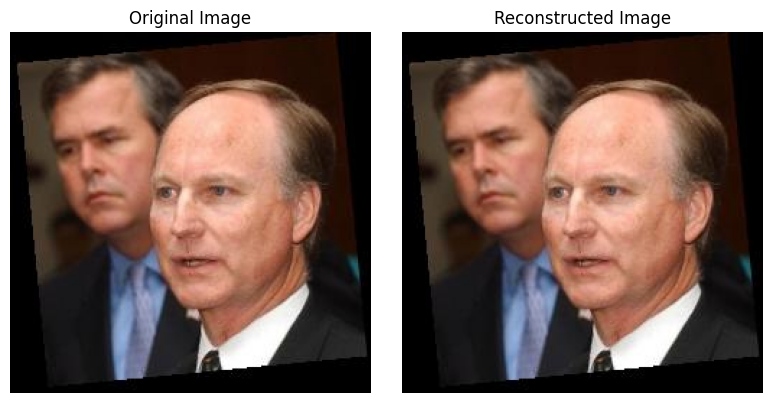

In [20]:
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import random

# Set the model to evaluation mode
model.eval()

# Select a random image from the dataset
random_index = random.randint(0, len(sample_image) - 1)
input_image= sample_image[random_index]

# Pass the input image through the model to get the reconstructed image
with torch.no_grad():
    input_image = input_image.unsqueeze(0)  # Add batch dimension
    input_image = input_image  # Move to the appropriate device
    reconstructed_image = model(input_image)

# Convert tensors to NumPy arrays for visualization
input_image = input_image.squeeze(0).cpu().numpy()
reconstructed_image = reconstructed_image.squeeze(0).cpu().numpy()

# Plot the original and reconstructed images side by side
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(input_image.transpose(1, 2, 0))  # Transpose to (H, W, C) format
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image.transpose(1, 2, 0))
plt.axis('off')

plt.tight_layout()
plt.show()

In [22]:
print(sample_image.size())


torch.Size([32, 3, 250, 250])


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

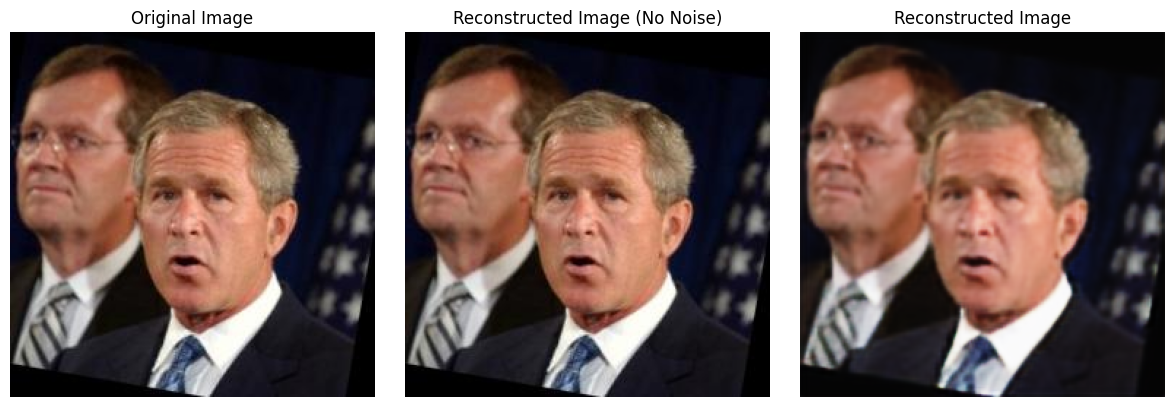

In [32]:
import torch
import matplotlib.pyplot as plt
import random
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms


# Select a random image from the dataset
random_index = random.randint(0, len(sample_image) - 1)
input_image= sample_image[random_index]

# Pass the input image through the model to get the latent representation
with torch.no_grad():
    input_image = input_image.unsqueeze(0)  # Add batch dimension
    input_image = input_image  # Move to the appropriate device
    latent_representation = model.encoder(input_image)

# Add small normally distributed noise to the latent representation
noise = torch.randn_like(latent_representation) * 0.3  # Adjusting the noise scale as needed
noisy_representation = latent_representation + noise

# Decode the noisy latent representation
with torch.no_grad():
    noisy_reconstructed_image = model.decoder(noisy_representation)

# Convert tensors to NumPy arrays for visualization, making sure to detach them
input_image_np = input_image.squeeze(0).cpu().detach().numpy()
reconstructed_image = model.decoder(latent_representation)  # Decoding the original latent representation
reconstructed_image_np = reconstructed_image.squeeze(0).cpu().detach().numpy()
noisy_reconstructed_image_np = noisy_reconstructed_image.squeeze(0).cpu().detach().numpy()

# Ensure pixel values are within the valid range [0, 1]
input_image_np = input_image_np.clip(0, 1)
reconstructed_image_np = reconstructed_image_np.clip(0, 1)
noisy_reconstructed_image_np = noisy_reconstructed_image_np.clip(0, 1)

# Plot the original, reconstructed, and noisy reconstructed images
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(input_image_np.transpose(1, 2, 0))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Reconstructed Image (No Noise)")
plt.imshow(reconstructed_image_np.transpose(1, 2, 0))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Reconstructed Image")#with noise
plt.imshow(noisy_reconstructed_image_np.transpose(1, 2, 0))
plt.axis('off')

plt.tight_layout()
plt.show()

This code adds small normally distributed noise to the latent representation obtained from the encoder and then decodes it again. By visualizing the reconstructed image with added noise, you can observe how the noise affects the final output. This can provide insights into the robustness and generalization capabilities of the autoencoder.